# Algorithms



In [1]:
# import libraries and csv file

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import time

data = pd.read_csv('Cleaned_Data.csv')

In [2]:
data.head(10)

,truck_type,value,distance,special
0,Reefer,2024.01,2585,False
1,Reefer,1931.33,2106,False
2,Van,1709.99,3280,False
3,Reefer,3406.64,2082,False
4,Reefer,1189.01,2464,False
5,Van,1468.45,2234,False
6,Van,1355.33,3141,False
7,Van,1649.94,1786,True
8,Flatbed,2037.55,3375,False
9,Reefer,1874.20,3595,False


# Partition Algorithm

Function 1 - Baseline

- Start by writing a very simple algorithm to partition the data. This will act as your baseline for comparing your next one(s). This simple algorithm does not need to satisfy every constraint well (or at all!) but should at least produce the correct number of partitions, and include some randomization.

Requirements:
1. The user can decide to use any number of partitions, from 1, up to the size of the dataset
itself
2. No row should ever be duplicated, modified, or left out. Each row should appear in
exactly one partition.
3. Each partition should have as close to the same number of rows as each other
4. Each partition should have as close to the same number of rows from each category of
shipment, R, V, and F
5. The sum of the “value” column for each partition should be approximately the same
6. The sum of the “value” column for each class (R, V, F) in each partition should be
approximately the same.
7. Partitions should be randomized, so that repeated partitioning tasks would not
necessarily produce the same result each time.

Before we dive into the algorithm, lets define the metrics to classify a "successful algorithm":

In [3]:
#  1 & 2 - No row should ever be duplicated, modified, or left out. Each row should appear in 
#  exactly one partition.
#     - if the there are no duplicates and each partition length sums to the initial dataset 
#       length, then this entire requirement is met
#     - ie : just check if any loads are duplicated in each partition


# 3 - Each partition should have as close to the same number of rows as each other
#     - ie : just compare len(partitions[i])
    
    
# 4 - Each partition should have as close to the same number of rows from each category of shipment, R, V, and F
#     --> len(partitions[partitions[i] == truck_type]) for all 3 truck types


# 5 - The sum of the “value” column for each partition should be approximately the same
#     --> partitions['value'].sum() for all partitions
    
    
# 6 -  The sum of the “value” column for each class (R, V, F) in each partition should be approximately the same.
#     --> partitions[partitions[i] == truck_type]['value'].sum()


# 7 - Partitions should be randomized, so that repeated partitioning tasks would not necessarily produce the same result each time.
#     --> use random_integer input

In [4]:
# algorithm input --> input of number ranging from 1-1000 and random_state

def partitionFunction1(partitions, random_state):
    
    # copy data into another dataframe so function can be called multiple times without reloading page
    iterable_data_set = data.copy()
    
    # 1 - define partition size and remainder to track during loop
    partition_size = iterable_data_set.shape[0] / partitions
    remainder = abs(partition_size - round(partition_size, 0))
    
    # 2 - sample from each truck type dataframe
    # 2a - initialize dictionary to store partitioned datasets
    partitioned_datasets = {}
    
    # initialize remaining average loads per partition after pulling from initial dataset
    running_average_capture = []
        
    for g in range(partitions):

        running_average = len(iterable_data_set) / (partitions - g)
        
        running_average_capture.append(running_average)

        if g == (partitions - 1):
            partitioned_datasets[g] = iterable_data_set

        elif (running_average > partition_size):
            partitioned_datasets[g] = iterable_data_set.sample(n=int(partition_size + 1), random_state=random_state)
            sample_index_list = partitioned_datasets[g].index.tolist()
            iterable_data_set.drop(sample_index_list, axis=0, inplace=True)

        else:
            partitioned_datasets[g] = iterable_data_set.sample(n=int(partition_size), random_state=random_state)
            sample_index_list = partitioned_datasets[g].index.tolist()
            iterable_data_set.drop(sample_index_list, axis=0, inplace=True)
        
        # plot running average vs paritions
        plt.plot(running_average_capture)
        plt.title('Running Average of Remainder')
        plt.xlabel('Paritions')
        plt.ylabel('Remainder Value')
        plt.axhline(y=math.ceil(partition_size), color='red', linestyle='--', label = "Upper Bound")
        plt.axhline(y=partition_size, color='blue', linestyle='--', label = "Partition Average")
        plt.axhline(y=math.floor(partition_size), color='red', linestyle='--', label = "Lower Bound")
        
    return partitioned_datasets
            


# Algorithm Test Function

In [8]:
# report on algorithm metrics
    
def AlgorithmResults(num_of_partitions, random_state, function):
    
    before_algorithm = time.time()
    
    partitioned_datasets = function(num_of_partitions, random_state)
    
    after_algorithm = time.time()
    
    
    before_test = time.time()
    
    # initilize a dataframe for test function results to be displayed
    columns = ['Load Count', 
               'Duplicates', 
               'Reefer Count',
               'Van Count',
               'Flatbed Count',
               'Sum of Values',
               'Sum of Reefer Values',
               'Sum of Van Values',
               'Sum of Flatbed Values',
              ]

    index = range(0, len(partitioned_datasets))

    test_results = pd.DataFrame(columns=columns, index=index)
    
    # initialize list to store index arrays for duplication check
    index_list = []

    # loop thru partitions to extract index lists and add them into one
    for i in range(len(partitioned_datasets)):
        
        # get index list of each partition
        test_results.iloc[i, 0] = len(partitioned_datasets[i])
        
        # get duplicates in each partition
        duplicates = [number for number in (partitioned_datasets[i].index.tolist()) if (partitioned_datasets[i].index.tolist()).count(number) > 1]
        test_results.iloc[i, 1] = len(duplicates)
        
        # get count of each truck type in each partition
        unique_truck_types = list(partitioned_datasets[i]['truck_type'].unique())
        
        # initialize dictionary to tie truck type to test_results location
        type_to_location = {'Reefer':2, 'Van':3, 'Flatbed':4}
        
        # add truck type counts to test_results
        for g in unique_truck_types:
            test_results.iloc[i, type_to_location[g]] = partitioned_datasets[i]['truck_type'].value_counts()[g]
            
        # fill NaN with 0
        test_results['Reefer Count'].fillna(0, inplace=True)
        test_results['Van Count'].fillna(0, inplace=True)
        test_results['Flatbed Count'].fillna(0, inplace=True)
        
        
        # get sum of partition value column
        test_results.iloc[i, 5] = partitioned_datasets[i]['value'].sum()
                
        # get sum of partition value column for per truck types
        reefer_partition = partitioned_datasets[i][partitioned_datasets[i]['truck_type'] == 'Reefer']
        van_partition = partitioned_datasets[i][partitioned_datasets[i]['truck_type'] == 'Van']
        flatbed_partition = partitioned_datasets[i][partitioned_datasets[i]['truck_type'] == 'Flatbed']
        
        # add values to test_results
        test_results.iloc[i, 6] = reefer_partition['value'].sum()
        test_results.iloc[i, 7] = van_partition['value'].sum()
        test_results.iloc[i, 8] = flatbed_partition['value'].sum()
        
        # add index's to one list
        index_list += partitioned_datasets[i].index.tolist()
        
        final_results = test_results.T
        
        # output summary statistics for each parition
        # final_results['Standard Deviation'] = round(final_results.std(axis=1), 0)
        final_results['Sum'] = round(final_results.sum(axis=1), 0)
        
    after_test = time.time()
    
    test_time = (after_test-before_test)*1000
    algorithm_time = (after_algorithm-before_algorithm)*1000
    
    print('Test function took ' + str(test_time) + 'ms')
    print('Algorithm took ' + str(algorithm_time) + 'ms')
    
    return final_results
    
    

Test function took 209.3520164489746ms
Algorithm took 168.62225532531738ms


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,Sum
Load Count,47,48,48,47,48,48,47,48,47,48,...,48,48,47,48,47,48,48,47,48,1000.0
Duplicates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Reefer Count,16,14,16,20,16,19,20,17,23,22,...,18,27,21,21,17,22,19,16,20,403.0
Van Count,19,22,20,13,25,21,18,23,17,14,...,17,13,19,17,21,14,18,19,20,390.0
Flatbed Count,12,12,12,14,7,8,9,8,7,12,...,13,8,7,10,9,12,11,12,8,207.0
Sum of Values,79629.19,98840.25,116070.59,90723.89,109846.54,102688.76,108468.68,97987.95,94160.13,85281.78,...,106603.34,85039.54,101011.65,92689.59,93744.54,104882.17,109031.94,88452.85,104772.35,2070839.0
Sum of Reefer Values,27666.08,27034.01,38597.44,45321.86,33633.96,39526.41,47177.17,38302.71,50658.95,38466.33,...,41570.86,48407.09,48367.5,30924.9,36115.53,44680.37,40676.86,27294.86,33768.27,809203.0
Sum of Van Values,30549.63,44732.74,46148.87,19590.21,58686.64,46617.92,37693.38,40443.71,30869.6,21929.98,...,36190.97,23670.84,38105.1,33903.32,42502.89,32875.28,44730.41,35635.71,50035.38,803045.0
Sum of Flatbed Values,21413.48,27073.5,31324.28,25811.82,17525.94,16544.43,23598.13,19241.53,12631.58,24885.47,...,28841.51,12961.61,14539.05,27861.37,15126.12,27326.52,23624.67,25522.28,20968.7,458591.0


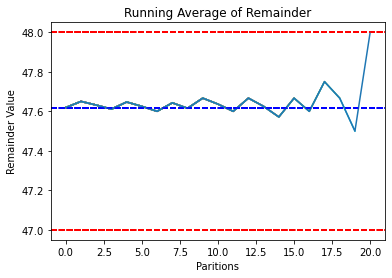

In [9]:
AlgorithmResults(21, 1, partitionFunction1)

In [10]:
# Questions:
# 1. Describe how this algorithm works.

# Algorithm Process Steps:

#     1 - Load data

#     2 - Get user input for partition size and randomizer value

#     3 - Define partition size

#     4 - Loop through dataset extracting loads from main dataset into another dictionary for analysis

#         4a - Track remainder_value - ie if partition size is uneven, the remainder will grow/ shrink based on 
#              whether you round up or down when sampling 
#              NOTE: See remainder chart outputed from algorithm to see this in action

#         4b - if remainder value < average parition size --> round up on sample size (ceiling)

#         4c - if remainder value > average parition size --> round down on sample size (floor)

#         4d - sample from dataset based on remainder value

#         4e - add samples to dictionary (maintaining index)

#         4f - drop samples from initial dataset (by index)

#         4g - on the last partition add the remaining inital dataset

#      5 - END

In [11]:
# 2. What do the results look like when partitioning the data set?

# The algorithm returns loads on n_paritions as defined!
# Based on the success metrics this algorithm succeeds in 4/7 success metrics

# No loads are duplicated / modified
# No loads are left out
# Each partition has close to the same number of loads
# Partition sampling can be randomized based on random_state user input

# This algorithm does not care about truck_type or sum of values
# I will add this to the next algorithm



# Function 2 - Improving the Algorithm

Now write another algorithm that you think will improve the results on at least one of the
constraints.

In [12]:
# This algorithm needs to satisfy these 3 conditions:

# 4 - Each partition should have as close to the same number of rows from each category of shipment, R, V, and F
#     --> len(partitions[partitions[i] == truck_type]) for all 3 truck types


# 5 - The sum of the “value” column for each partition should be approximately the same
#     --> partitions['value'].sum() for all partitions
    
    
# 6 -  The sum of the “value” column for each class (R, V, F) in each partition should be approximately the same.
#     --> partitions[partitions[i] == truck_type]['value'].sum()

In [13]:
# algorithm input --> input of number ranging from 1-1000 and random_state

def partitionFunction2(partitions, random_state):
    
    # copy data into another dataframe so function can be called multiple times
    iterable_data_set = data.copy()
    
    # 1 - define partition size
    partition_size = iterable_data_set.shape[0] / partitions
    remainder = abs(partition_size - round(partition_size, 0))
    
    # average load value to maintain same value sum in each partition
    avg_load_value = len(iterable_data_set) / iterable_data_set['value'].sum()
    
    # get percentages for each truck_type
    truck_type_counts = data.truck_type.value_counts()
    reefer_percent = round(truck_type_counts['Reefer'] / data.shape[0], 2)
    van_percent = round(truck_type_counts['Van'] / data.shape[0], 2)
    flatbed_percent = round(truck_type_counts['Flatbed'] / data.shape[0], 2)
    
    # truck type partition sizes to maintain same number of truck_types in each parition
    flatbed_partition_size = partition_size * flatbed_percent
    van_partition_size = partition_size * van_percent
    reefer_partition_size = partition_size * reefer_percent
    
    # truck_type value to maintain same value sum in each partition per truck_type
    flatbed_target_sum_value = flatbed_partition_size * avg_load_value
    van_target_sum_value = van_partition_size * avg_load_value
    reefer_target_sum_value = reefer_partition_size * avg_load_value
    
    # initialize lists to append tracker metrics during for loop
    avg_sum_running_average = []
    flatbed_sum_running_average = []
    van_sum_running_average = []
    reefer_sum_running_average = []
    flatbed_count_running_average = []
    van_count_running_average = []
    reefer_count_running_average = []
    running_average_capture = []
    value_target_capture = []
    current_value_target = []
    current_value_target_capture = []
    
        
    # 2 - sample from each truck type dataframe (same percent from each truck type)
    # 2a - initialize dictionary to store partitioned datasets
    partitioned_datasets = {}  
    
    for g in range(partitions):
        
        # define current value sum target
        value_target = avg_load_value * (g + 1)
        value_target_capture.append(value_target)

        # define current value sum
        current_value_target = iterable_data_set['value'].sum() / (partitions - g)
        current_value_target_capture.append(current_value_target)

        # define running average target
        running_average = len(iterable_data_set) / (partitions - g)
        running_average_capture.append(running_average)
        
        if g == (partitions - 1):
            partitioned_datasets[g] = iterable_data_set
        
        else:
            partitioned_datasets[g] = pd.DataFrame(columns=iterable_data_set.columns)
            
            for i in range(int(partition_size)):
                
                sample = iterable_data_set.sample(n=1, replace=False, random_state=random_state)
                partitioned_datasets[g] = partitioned_datasets[g].append(sample.iloc[[0]])
                iterable_data_set.drop(sample.index.tolist(), axis=0, inplace=True)
                

#     # plot current target vs paritions
#     plt.plot(value_target_capture, current_value_target_capture)
#     plt.title('Current Target of Remainder')
#     plt.xlabel('Paritions')
#     plt.ylabel('Current Target')
    
    # plot running average vs paritions
    plt.plot(running_average_capture)
    plt.title('Running Average of Remainder')
    plt.xlabel('Paritions')
    plt.ylabel('Remainder Value')
    plt.axhline(y=math.ceil(partition_size), color='red', linestyle='--', label = "Upper Bound")
    plt.axhline(y=partition_size, color='blue', linestyle='--', label = "Partition Average")
    plt.axhline(y=math.floor(partition_size), color='red', linestyle='--', label = "Lower Bound")

          
    return partitioned_datasets
            


Test function took 1250.75101852417ms
Algorithm took 2756.4542293548584ms


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,Sum
Load Count,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,100,1000.0
Duplicates,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
Reefer Count,6,4,2,3,3,3,5,2,6,2,...,3,2,6,5,2,3,4,3,40,403.0
Van Count,0,1,5,4,4,5,4,5,2,3,...,4,3,3,3,5,5,4,3,40,390.0
Flatbed Count,3,4,2,2,2,1,0,2,1,4,...,2,4,0,1,2,1,1,3,20,207.0
Sum of Values,12923.78,19445.72,22353.2,13756.16,16746.92,12579.77,18866.55,16243.37,24338.04,15488.02,...,14971.24,23707.99,19857.49,17387.65,15413.11,17253.39,15344.54,17660.11,199530.84,2070839.0
Sum of Reefer Values,8513.19,6372.17,3803.81,4594.48,5460.48,4046.76,10004.78,3557.97,8377.68,3649.12,...,4165.56,10126.34,9699.43,8256.29,5719.66,5878.92,9249.04,4362.84,70923.81,809203.0
Sum of Van Values,0.0,1333.97,10943.58,5944.39,5594.23,6559.46,8861.77,7081.45,8633.86,6276.89,...,7644.44,5515.86,10158.06,7409.61,7091.66,9590.84,4670.72,8447.9,81485.07,803045.0
Sum of Flatbed Values,4410.59,11739.58,7605.81,3217.29,5692.21,1973.55,0.0,5603.95,7326.5,5562.01,...,3161.24,8065.79,0.0,1721.75,2601.79,1783.63,1424.78,4849.37,47121.96,458591.0


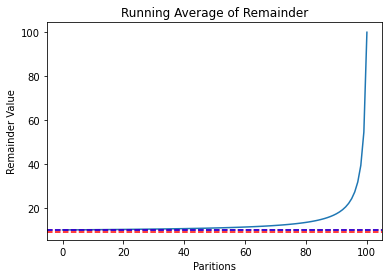

In [15]:
AlgorithmResults(101, 1, partitionFunction2)

In [ ]:
    # if load[i] > current_target : find load < previous load
    # add value to current_value
    for g in len(flatbed_partition_size)():
        if new_flatbed_partition[i] >= current_target:
            # add load with value less than current_target
            new_flatbed_partition.append(flatbed_partition_size[i])
            # add load value to current_value
            current_value += flatbed_partition_size['value'][i]
            # drop load from dataset
            ????
            
            else:
                # add load with value less than current_target
                new_flatbed_partition.append(flatbed_partition_size[i])
                # add load value to current_value
                current_value += flatbed_partition_size['value'][i]
                # drop load from dataset
                ????

In [19]:
# algorithm input --> input of number ranging from 1-1000 and random_state

def partitionFunction3(partitions, random_state):
    
    # copy data into another dataframe so function can be called multiple times
    iterable_data_set = data.copy()
    
    # 1 - define partition size
    partition_size = iterable_data_set.shape[0] / partitions
    remainder = abs(partition_size - round(partition_size, 0))
    
    # average load value to maintain same value sum in each partition
    avg_load_value = len(iterable_data_set) / iterable_data_set['value'].sum()
    
    # get percentages for each truck_type
    truck_type_counts = data.truck_type.value_counts()
    reefer_percent = round(truck_type_counts['Reefer'] / data.shape[0], 2)
    van_percent = round(truck_type_counts['Van'] / data.shape[0], 2)
    flatbed_percent = round(truck_type_counts['Flatbed'] / data.shape[0], 2)
    
    # truck type partition sizes to maintain same number of truck_types in each parition
    flatbed_partition_size = partition_size * flatbed_percent
    van_partition_size = partition_size * van_percent
    reefer_partition_size = partition_size * reefer_percent
    
    # truck_type value to maintain same value sum in each partition per truck_type
    flatbed_target_sum_value = flatbed_partition_size * avg_load_value
    van_target_sum_value = van_partition_size * avg_load_value
    reefer_target_sum_value = reefer_partition_size * avg_load_value
    
    # initialize lists to append tracker metrics during for loop
    avg_sum_running_average = []
    flatbed_sum_running_average = []
    van_sum_running_average = []
    reefer_sum_running_average = []
    flatbed_count_running_average = []
    van_count_running_average = []
    reefer_count_running_average = []
    running_average_capture = []
        
        
        
    # 2 - sample from each truck type dataframe (same percent from each truck type)
    # 2a - initialize dictionary to store partitioned datasets
    partitioned_datasets = {}    
    
    
    for g in range(partitions):

        # define current value sum target
        current_target = avg_load_value * (g + 1)

        running_average = len(iterable_data_set) / (partitions - g)
        running_average_capture.append(running_average)        
        
        if g == (partitions - 1):
            partitioned_datasets[g] = iterable_data_set

        elif (running_average > partition_size):
            partitioned_datasets[g] = pd.concat([
                                iterable_data_set[iterable_data_set['truck_type'] == 'Flatbed'].sample(n=int(math.ceil(flatbed_partition_size)), random_state = random_state), 
                                iterable_data_set[iterable_data_set['truck_type'] == 'Van'].sample(n=int(math.ceil(van_partition_size)), random_state = random_state), 
                                iterable_data_set[iterable_data_set['truck_type'] == 'Reefer'].sample(n=int(math.ceil(reefer_partition_size)), random_state = random_state)
                                                ])
            sample_index_list = partitioned_datasets[g].index.tolist()
            iterable_data_set.drop(sample_index_list, axis=0, inplace=True)
            
        else:
            partitioned_datasets[g] = pd.concat([
                                iterable_data_set[iterable_data_set['truck_type'] == 'Flatbed'].sample(n=int(math.floor(flatbed_partition_size)), random_state = random_state), 
                                iterable_data_set[iterable_data_set['truck_type'] == 'Van'].sample(n=int(math.floor(van_partition_size)), random_state = random_state), 
                                iterable_data_set[iterable_data_set['truck_type'] == 'Reefer'].sample(n=int(math.floor(reefer_partition_size)), random_state = random_state)
                                                ])
            sample_index_list = partitioned_datasets[g].index.tolist()
            iterable_data_set.drop(sample_index_list, axis=0, inplace=True)
            
            
    # plot running average vs paritions
    plt.plot(running_average_capture)
    plt.title('Running Average of Remainder')
    plt.xlabel('Paritions')
    plt.ylabel('Remainder Value')
    plt.axhline(y=math.ceil(partition_size), color='red', linestyle='--', label = "Upper Bound")
    plt.axhline(y=partition_size, color='blue', linestyle='--', label = "Partition Average")
    plt.axhline(y=math.floor(partition_size), color='red', linestyle='--', label = "Lower Bound")
          
    return partitioned_datasets
            

In [13]:
# # for loop for each truck_type dataset

# # add search thru truck_type datasets and add loads based on current_value
# for i in len(flatbed_partition_size)():    
    
#     # define target
#     current_target = avg_load_value * (i + 1)
    
#     # define current value sum
#     current_value = 0
    
    
#     # if load[i] < current_target : find load > previous load
#     # add value to current_value


# # remove samples from initial dataset
# # data.drop(flatbed_sample.index, axis=0, inplace=True)